In [2]:
# Подключение пакетов
import os, time, sys
from math import pi
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('Uproot version:',uproot.version.version)
print('Numpy version:', np.version.version)

# инициализация генератора псевдослучайных чисел
rng = np.random.default_rng(12345)

Uproot version: 3.14.4
Numpy version: 1.23.5


In [3]:
# Определение источника данных
# filepath = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root'
filepath = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root'

if os.path.exists(filepath):
  print('Simulation data found in "{}"'.format(filepath))
else:
  raise FileNotFoundError('Could not find simulation file')

Simulation data found in "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root"


In [4]:
# Директория для хранения данных
datadir = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data'

In [5]:
# отображение ключей в файле uproot в виде иерархии
def show_uproot_tree(obj, maxkeylen=12, sep='/', indent=0):
  width = maxkeylen+len(sep)
  startline = False
  if isinstance(obj, uproot.rootio.ROOTDirectory):
    print('TFile: '+obj.name.decode('utf-8'))
    startline = True
    indent = 2
  elif issubclass(type(obj), uproot.tree.TTreeMethods):
    print('TTree: '+obj.name.decode('utf-8'))
    startline = True
    indent = 4
  else:
    if len(obj.keys()) > 0:
      indent += width
      s = obj.name.decode('utf-8')[:maxkeylen]
      print(s + ' '*(maxkeylen-len(s)) + sep, end='')
    else:
      print(obj.name.decode('utf-8'))

  if len(obj.keys()) > 0:
    for i, key in enumerate(obj.keys()):
      if i>0 or startline:
        print(' '*indent, end='')
      show_uproot_tree(obj[key], indent=indent)
    indent -= width

In [6]:
show_uproot_tree(uproot.open(filepath))

TFile: ./farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root
  TTree: info_sim
    info_gen    /m_num_events
                 m_z_dis
    info_rad    /m_layers    /m_layers.first
                              m_layers.second
    info_pmt    /m_name
                 m_num_side_x
                 m_num_side_y
                 m_gap
                 m_size
                 m_chip_num_size
                 m_chip_pitch
                 m_chip_size
                 m_chip_offset
                 m_focal_length
                 m_trg_window
                 m_origin_pos/m_origin_pos._2
                              m_origin_pos._1
                              m_origin_pos._0
  TTree: raw_data
    event       /m_id_event
                 m_id_primary
                 m_pos_primar/m_pos_primary._2
                              m_pos_primary._1
                              m_pos_primary._0
                 m_dir_primar/m_dir_primary._2
                              m_dir_primary._1
 

In [7]:
def readInfoFromRoot(rootfilename, verbose: bool = False):
  '''
  Получение информации о моделировании из ROOT-файла в виде датафрейм формы (1, N), где N - число параметров.

  Описание условий моделирования:
    Ось Z направлена по нормали к плоскости радиатора от радиатора к фотодетектору.
    Оси X и Y паралельны осям симметрии матрицы фотодетектора.
    Первичная частица (отрицательный пион) вылетает на расстоянии zdis=1 мм перед радиатором в его сторону
    Начальное положение частицы случайно разбрасывается по X и Y в квадрате со стороной (pixel_size+pixel_gap).
    Направление частицы случайно разбрасывается в телесном угле в пределах theta_p=[0, π/4], phi_p=[0, 2π].
    Скорость частицы случайно и равномерно разбрасывается от 0.957 до 0.999 скорости света.
  '''
  # Названия используемых колонок данных для переименования и сохранения в data frame
  idf_rename_map = {'m_num_events': 'nevents',  # число событий моделирования
                    'm_z_dis': 'zdis',  # расстояние от места рождения частицы до входа в радиатор в мм
                    'm_layers': 'nlayers',  # число слоев радиатора
                    'm_size': 'array_size',  # размер матрицы КФУ в мм
                    'm_gap': 'array_gap',  # зазор между матрицами КФУ в мм
                    'm_chip_size': 'pixel_size',  # размер пикселя КФУ в мм
                    'm_chip_pitch': 'pixel_gap',  # зазор между пикселями КФУ в мм
                    'm_chip_num_size': 'pixel_numx',  # размер матрицы КФУ в пикселях
                    'm_num_side_x': 'nxarrays', 'm_num_side_y': 'nyarrays',  # размер фотодетектора в матрицaх КФУ по X и Y
                    'm_focal_length': 'distance',  # расстояние вдоль Z от входа в радиатор до входа в фотодетектор
                    'm_trg_window': 'trg_window_ns',  # размер временного окна в нс
                    'W': 'W',  # толщина радиатора в мм (вычисляемая)
                    'n_mean': 'n_mean',  # средний показатель преломления радиатора (вычисляемый)
                    'n_max': 'n_max',  # максимальный показатель преломления радиатора (вычисляемый)
                    'm_origin_pos._0': 'x_center',  # положение центра фотодетектора по X в мм (0)
                    'm_origin_pos._1': 'y_center'   # положение центра фотодетектора по Y в мм  (0)
                   }

  # Открытие ROOT-файла с данными используя Uproot https://github.com/scikit-hep/uproot3
  with uproot.open(rootfilename) as file:
    idf = file[b'info_sim'].pandas.df('*', flatten=False)
    # print(idf['m_origin_pos._0'])

  # Переименование параметров
  idf.rename(columns=idf_rename_map, inplace=True, errors='ignore')

  # Получение параметров (многослойного) радиатора одинаковых для всех файлов
  n_l = idf.at[0, 'm_layers.first']  # показатели преломления слоёв
  w_l = idf.at[0, 'm_layers.second']  # толщины слоёв радиатора

  W = w_l.sum()  # суммарная толщина всех слоёв
  n_mean = n_l.mean()  # средний показатель преломления
  n_max = n_l.max()  # максимальный показатель преломления

  # Добавление вычисляемых параметров в idf
  idf['W'] = W
  idf['n_mean'] = n_mean
  idf['n_max'] = n_max

  # Сохранение нужных параметров
  idf = idf[idf_rename_map.values()]

  if verbose:
    print(idf)

  return idf

In [7]:
idf = readInfoFromRoot(filepath)
print(idf.iloc[0])


nevents          120000.0000
zdis                  1.0000
nlayers               4.0000
array_size           26.6800
array_gap             1.0000
pixel_size            3.1600
pixel_gap             0.2000
pixel_numx            8.0000
nxarrays             30.0000
nyarrays             30.0000
distance            200.0000
trg_window_ns        20.0000
W                    35.0000
n_mean                1.0454
n_max                 1.0500
x_center              0.0000
y_center              0.0000
Name: 0, dtype: float64


In [8]:
def getAxisSize(x_center, nxarrays, array_size, gap, pixel_numx, pixel_size):
  '''
  Вычисление дискретной сетки вдоль оси
  '''
  xmin = x_center - nxarrays * (array_size + gap) / 2
  xmax = x_center + nxarrays * (array_size + gap) / 2
  nbins = nxarrays * pixel_numx
  return np.linspace(xmin, xmax, nbins+1, endpoint=True)

def getBoardSize(idf):
  '''
  Вычисление двухмерной дискретной сетки 
  '''
  xedges = getAxisSize(
    idf.at[0, 'x_center'], idf.at[0, 'nxarrays'], idf.at[0, 'array_size'], idf.at[0, 'array_gap'], idf.at[0, 'pixel_numx'], idf.at[0, 'pixel_size'])
  yedges = getAxisSize(
    idf.at[0, 'y_center'], idf.at[0, 'nyarrays'], idf.at[0, 'array_size'], idf.at[0, 'array_gap'], idf.at[0, 'pixel_numx'], idf.at[0, 'pixel_size'])

  return (xedges, yedges)

In [9]:
xedges, yedges = getBoardSize(idf)
print('x: min={0:.2f} max={1:.2f} step={2:.3f}'.format(np.min(xedges), np.max(xedges), xedges[1]-xedges[0]))
print('y: min={0:.2f} max={1:.2f} step={2:.3f}'.format(np.min(yedges), np.max(yedges), yedges[1]-yedges[0]))

x: min=-415.20 max=415.20 step=3.460
y: min=-415.20 max=415.20 step=3.460


In [10]:
def digitizeAndRandomize(rootfilename: str, hdfilename: str, shiftTime: float = 5, timeSpan: tuple = (1, 10),
                         shiftPos: int = 32, boardSize: int = 64, noisefreqpersqmm: float = 1e6, hitmask: bool = False,
                         events: int = None, verbose: bool = False, timing: bool = False):
  """ Оцифровывает и аугментирует события из ROOT-файла и записывает в pandas.DataFrame. Каждое событие в результирующем DataFrame представляет 
  собой массив времен срабатываний в двумерном массиве каналов размером boardSize*boardSize. К сигнальным срабатываниям добавляются шумовые с 
  заданной частотой на кв. мм.

  Аргументы:
      rootfilename (str): путь к ROOT-файлу для чтения
      hdfilename (str): путь к HDF-файлу для записи датафрейма
      shiftTime (float, optional): максимальный случайный сдвиг сигнальных срабатываний по времение в нс. По умолчанию 5.
      timeSpan (2-tuple, optional): диапазон ROI по времени для срабатываний в нс 
                                    (в результирующем датафрейме значения 0 соответствуют отсутствию срабатывания). По умолчанию (1, 11).
      shiftPos (int, optional): максимальный случайный сдвиг положения сигнальных срабатываний по X и Y. По умолчанию 32.
      boardSize (int, optional): размер области интереса (ROI) в каналах по одной координате. По умолчанию 64.
      noisefreqpersqmm (float, optional): частота шумов на кв. мм. По умолчанию 1e6.
      events (int | None, optional): число событий для чтения; если None, читать все. По умолчанию None.
      verbose (bool, optional): флаг более подробной печати. По умолчанию False.
  """
  global rng

  start0 = time.perf_counter()

  # Поля данных (для переименования и сохранения)
  part_rename_map = {'m_hits': 'nhits',           # число срабатываний от черенковских фотонов
                     'm_beta_primary': 'beta',    # скорость частицы в единицах скорости света
                     'm_theta_primary': 'theta_p',# полярный угол направления частицы в радианах
                     'm_phi_primary': 'phi_p',    # азимутальный угол направления частицы в радианах
                     'm_momentum_primary': 'momentum',  # импульс частицы в МэВ/c
                     'm_pos_primary._0': 'x_p',   # X-координата вылета частицы в мм
                     'm_pos_primary._1': 'y_p',   # Y-координата вылета частицы в мм
                     'm_pos_primary._2': 'z_p',   # Z-координата вылета частицы в мм
                     'm_dir_primary._0': 'nx_p',  # X-компонента единичного вектора направления частицы
                     'm_dir_primary._1': 'ny_p',  # Y-компонента единичного вектора направления частицы
                     'm_dir_primary._2': 'nz_p'   # Z-компонента единичного вектора направления частицы
                     }

  hit_rename_map = {'m_hits.m_photon_pos_chip._0': 'x_c',  # X-координата срабатывания в мм
                    'm_hits.m_photon_pos_chip._1': 'y_c',  # Y-координата срабатывания в мм
                    'm_hits.m_photon_pos_chip._2': 'z_c',  # Z-координата срабатывания в мм
                    'm_hits.m_photon_time': 't_c'          # время срабатывания в нс
                    }

  # Чтение параметров моделирования
  idf = readInfoFromRoot(filepath)
  
  nFileEvents = idf.at[0, 'nevents']  # число событий в моделировании
  print(f'Processing "{filepath}" with {nFileEvents} events', f'\n  and writing to "{hdfilename}"...')

  pdistance = idf.at[0, 'distance'] + idf.at[0, 'zdis']  # расстояние между местом вылета частицы и ФД вдоль Z

  nmax = idf.at[0, 'n_max']

  tof = (idf.at[0, 'distance'] - idf.at[0, 'W']/2) * idf.at[0, 'n_max'] / 300  # оценка времени пролета фотонов в нс
  
  pixel_size = idf.at[0, 'pixel_size']
  
  xedges, yedges = getBoardSize(idf)  # равномерная сетка для преобразования координат срабатываний в индексы пикселей

  numROIChannels = boardSize**2  # число каналов в области интереса
  
  minSignalHits = 4  # минимальное число сигнальных срабатываний в области интереса для признания события сигнальным

  hdfstore = pd.HDFStore(hdfilename, 'w', 2)  # хранилище для сохранения результирующего датафрейма

  hdfstore.put('idf', idf, 'f')  # сохранить параметры моделирования

  eventchunksize = 40000  # число событий для чтения за одну операцию
  
  if isinstance(events, int) and eventchunksize > events:
    eventchunksize = events

  nprocessed = 0  # число обработанных событий

  try:
    # Цикл чтения кусков ROOT-файла
    for pdf, hdf in zip(uproot.pandas.iterate(rootfilename, "raw_data", part_rename_map.keys(), entrysteps=eventchunksize),
                        uproot.pandas.iterate(rootfilename, "raw_data", hit_rename_map.keys(), entrysteps=eventchunksize, flatten=True)):

      # Переименование колонок
      pdf.rename(columns=part_rename_map, inplace=True, errors='raise')
      hdf.rename(columns=hit_rename_map, inplace=True, errors='raise')

      start = time.perf_counter()

      # Число событий
      nevents = pdf.shape[0]
      
      # Массив числа исходных срабатываний в событиях
      n0hits = pdf['nhits'].to_numpy('int16')

      # Полное число срабатываний
      ntot0hits = hdf.shape[0]
      
      # assert(nhits.sum() == ntothits)

      print(('\n' if verbose else '') + 
            f'  Processing chunk with {nevents} events and {ntot0hits} hits ({ntot0hits/nevents:.2f} hits/event)...', flush=True)

      if verbose:
        print('    Dataframes read from ROOT file:')
        print(pdf)
        print(hdf)

      nsigevents = (n0hits >= minSignalHits).sum()
      print(f'    Number of events with signal hits >= {minSignalHits}: {nsigevents} ({100.*nsigevents/nevents:.1f}%)')

      # Случайный сдвиг времени срабатываний по событиям 
      t = hdf['t_c'].to_numpy() + np.repeat(rng.uniform(-shiftTime, shiftTime, nevents), n0hits) - tof + (timeSpan[1]+timeSpan[0]) / 2

      # Вычисление места попадания частицы в ФД
      x_pd = (pdf['x_p'] + pdistance * pdf['nx_p'] / pdf['nz_p']).to_numpy()
      y_pd = (pdf['y_p'] + pdistance * pdf['ny_p'] / pdf['nz_p']).to_numpy()

      # Вычисление "центра" кольца
      # theta_c = np.arccos(1 / nmax / pdf['beta'])
      # theta1 = np.arcsin(nmax * np.sin(pdf['theta_p'] + theta_c))
      # theta2 = np.arcsin(nmax * np.sin(pdf['theta_p'] - theta_c))
      # r0 = 0.5 * pdistance * (np.tan(theta1) + np.tan(theta2))
      # x0 = pdf['x_p'] + r0 * np.cos(pdf['phi_p'])
      # y0 = pdf['y_p'] + r0 * np.sin(pdf['phi_p'])

      # Преобразование положений срабатываний в неравномерной сетке к положениям в равномерной сетке
      ix = np.digitize(hdf['x_c'], xedges)
      iy = np.digitize(hdf['y_c'], yedges)

      # Преобразование места попадания частицы к равномерной сетке
      ix_pd = np.digitize(x_pd, xedges)
      iy_pd = np.digitize(y_pd, yedges)

      # Преобразование "центра" кольца к равномерной сетке
      # ix0 = np.digitize(x0, xedges)
      # iy0 = np.digitize(y0, yedges)
      
      # тестовый датафрейм
      # r2_pd = (ix - np.repeat(ix_pd, n0hits))**2 + (iy - np.repeat(iy_pd, n0hits))**2
      # r2_0 = (ix - np.repeat(ix0, n0hits))**2 + (iy - np.repeat(iy0, n0hits))**2

      # r2df = pd.DataFrame({'event': hdf.index.get_level_values(0), 'r2_pd': r2_pd, 'r2_0': r2_0})
      # r2df = r2df.groupby('event').mean()
      # r2df['theta_p'] = pdf['theta_p']
      
      # Случайный сдвиг положения срабатываний по событиям
      dix = rng.integers(-shiftPos, shiftPos, nevents, endpoint=True) + boardSize // 2
      diy = rng.integers(-shiftPos, shiftPos, nevents, endpoint=True) + boardSize // 2
      ix += np.repeat(dix - ix_pd, n0hits)
      iy += np.repeat(diy - iy_pd, n0hits)

      # Маска срабатываний, попадающих в область интереса
      mask = (timeSpan[0] <= t) & (t < timeSpan[1]) & (0 <= ix) & (ix < boardSize) & (0 <= iy) & (iy < boardSize)

      # Индекс событий для отобранных срабатываний
      eindex = hdf.index.get_level_values(0)[mask]
      # print(eindex)

      # Индексы сработавших каналов
      ix = ix[mask]
      iy = iy[mask]
      ich = (iy*boardSize + ix).astype('int16')
      
      # Число сигнальных срабатываний по событиям      
      nsignalhits = np.bincount(eindex - pdf.index[0], minlength=nevents).astype('int16')
      ntotsighits = int(nsignalhits.sum())

      # assert(nsignalhits.size == nevents)
      # assert(mask.sum() == ntotsighits)
      
      print(f'    Number of signal hits in ROI: {ntotsighits} ({100.*ntotsighits/ntot0hits:.1f}%, {ntotsighits/nevents:.2f} hits/event)')
      nsigevents = (nsignalhits >= minSignalHits).sum()
      print(f'    Number of events with signal hits in ROI >= {minSignalHits}: {nsigevents} ({100.*nsigevents/nevents:.1f}%)')


      # Промежуточный датафрейм срабатываний
      if hitmask:
        bdf = pd.DataFrame({'event': eindex, 'ich': ich, 'hit': True})
      else:
        bdf = pd.DataFrame({'event': eindex, 'ich': ich, 't': t[mask].astype('float32')})
      if timing:
        print(f'    \u231A Digitizing and selecting hits: {time.perf_counter()-start:.3f} sec', flush=True)
      if verbose:
        print('    Auxilliary dataframe with signal hits')
        print(bdf)

      ### Добавление шумовых срабатываний ###
      if noisefreqpersqmm > 0:
        start = time.perf_counter()
        munoise = (timeSpan[1] - timeSpan[0]) * 1e-9 * noisefreqpersqmm * (pixel_size**2) * (boardSize**2)  # среднее число шумовых срабатываний на событие (скаляр)
        ndchits = rng.poisson(munoise, nevents).astype('int16')   # генерация массива числа шумовых срабатываний в событиях по пуассоновскому распределению (вектор)
        ntotdchits = int(ndchits.sum())           # общее число шумовых срабатываний (скаляр)
        edcindex = np.repeat(pdf.index, ndchits)  # индекс событий для шумовых срабатываний (вектор)

        print(f'    Number of DC hits generated (DCR={noisefreqpersqmm:.3g}): {ntotdchits} ({munoise:.2f} hits/event)', flush=True)

        # Создание промежуточного датафрейма с шумовыми срабатываниями
        ich_dc = rng.choice(boardSize**2, ntotdchits)  # генерация индексов сработавших каналов с возможным повтором
        if hitmask:
          bdf_dc = pd.DataFrame({'event': edcindex, 'ich': ich_dc, 'hit': True})
        else:
          t_dc = rng.uniform(*timeSpan, size=ntotdchits).astype('float32')  # генерация времён срабатываний по однородному распределению
          bdf_dc = pd.DataFrame({'event': edcindex, 'ich': ich_dc, 't': t_dc})

        if timing:
          print(f'    \u231A DC generation: {time.perf_counter()-start:.3f} sec', flush=True)
  
        # Слияние сигнальных и шумовых срабатываний в один датафрейм
        start = time.perf_counter()
        bdf: pd.DataFrame = pd.concat((bdf, bdf_dc), ignore_index=True, copy=False)
        if timing:
          print(f'    \u231A Concatenating: {time.perf_counter()-start:.3f} sec', flush=True)

      # Отбор одного срабатывания с минимальным временем в каждом канале
      start = time.perf_counter()
      bdf = bdf.groupby(['event', 'ich'], as_index=True, sort=True).min()
      if timing:
        print(f'    \u231A Grouping by: {time.perf_counter()-start:.3f} sec', flush=True)
      if verbose:
        print('     Groupped by channel dataframe')
        print(bdf)
      
      # Заполнение нулевыми значениями несработавших каналов
      start = time.perf_counter()
      mi = pd.MultiIndex.from_arrays([np.repeat(pdf.index, numROIChannels), np.tile(np.arange(numROIChannels), nevents)], names=bdf.index.names)
      bdf = bdf.reindex(mi, fill_value=(False if hitmask else 0.))
      if timing:
        print(f'    \u231A Reindexing: {time.perf_counter()-start:.3f} sec', flush=True)
      
      # Перевод номеров каналов из индекса в колонки
      start = time.perf_counter()
      edf = bdf.unstack(level=1)
      if timing:
        print(f'    \u231A Unstacking: {time.perf_counter()-start:.3f} sec', flush=True)
        
      del bdf

      # Удаление верхнего уровня индекса колонок. Необходимо для сохранения в HDF.
      edf.columns = edf.columns.droplevel(0)

      # Вычисление числа всех срабатываний после слияния
      nhits = (edf > 0).sum(axis=1).astype('int16')
      ntothits = nhits.sum()
      print(f'    Number of all hits after merging: {ntothits} ({ntothits/nevents:.2f} hits/event)', flush=True)

      # Добавление колонок с числом срабатываний и параметрами частицы
      start = time.perf_counter()
      edf['partin'] = (0 <= dix) & (dix < boardSize) & (0 <= diy) & (diy < boardSize)
      edf['nsignals'] = nsignalhits
      edf['n0signals'] = n0hits
      edf['nhits'] = nhits
      edf['beta'] = pdf['beta'].astype('float32')
      edf['theta_p'] = pdf['theta_p'].astype('float32')
      if timing:
        print(f'    \u231A Adding columns: {time.perf_counter()-start:.3f} sec', flush=True)

      if verbose:
        print('    Event dataframe')
        print(edf)

      start = time.perf_counter()
      hdfstore.put('edf', edf, 't', append=(nprocessed > 0))
      if timing:
        print(f'    \u231A Writing to HDF: {time.perf_counter()-start:.3f} sec', flush=True)

      # hdfstore.put('r2df', r2df, 't', append=(nprocessed > 0))

      nprocessed += nevents
      
      print(f'  {nprocessed} events stored', flush=True)

      if isinstance(events, int):
        if nprocessed >= events:
          break
        elif nprocessed + eventchunksize > events:
          eventchunksize = events - nprocessed

  finally:
    hdfstore.close()
  print(f'Done! \u231A {time.perf_counter()-start0:.3f} sec')  

In [11]:
# digitizeAndRandomize(filepath, os.path.join(datadir, 'test.h5'), timeSpan=(1, 10), shiftPos=45, boardSize=80, noisefreqpersqmm=0, verbose=False, timing=True)

In [14]:
filepath = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root'
datadir = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\ringdetection'
for dcr in (1e6, 1e5, 1e4, 1e3, 0):
    hdfname = f'digitized_x80_dx45_t1-3_dt2_120k_dcr{dcr:g}.h5'
    print(f'Digitizing with DCR = {dcr:g}')
    digitizeAndRandomize(filepath, os.path.join(datadir, hdfname), shiftTime=2, timeSpan=(1, 3), shiftPos=45, boardSize=80, noisefreqpersqmm=dcr, hitmask=True, verbose=False, timing=True)


Digitizing with DCR = 1e+06
Processing "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root" with 120000 events 
  and writing to "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\ringdetection\digitized_x80_dx45_t1-3_dt2_120k_dcr1e+06.h5"...
  Processing chunk with 40000 events and 816287 hits (20.41 hits/event)...
    Number of events with signal hits >= 4: 35087 (87.7%)
    Number of signal hits in ROI: 241592 (29.6%, 6.04 hits/event)
    Number of events with signal hits in ROI >= 4: 15810 (39.5%)
    ⌚ Digitizing and selecting hits: 0.098 sec
    Number of DC hits generated (DCR=1e+06): 5110529 (127.82 hits/event)
    ⌚ DC generation: 0.064 sec
    ⌚ Concatenating: 0.064 sec
    ⌚ Grouping by: 1.863 sec
    ⌚ Reindexing: 42.590 sec
    ⌚ Unstacking: 71.602 sec
    Number of all hits after merging: 5284108 (132.10 hits/event)
    ⌚ Adding columns: 0.043 sec
    ⌚ Writing to HDF: 10

In [43]:
# filepath = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root'
# for dcr in (1e6, 1e5, 1e4, 1e3, 0):
#     hdfname = f'digitized_x80_dx45_t1-10_dt5_120k_dcr{dcr:g}.h5'
#     print(f'Digitizing with DCR = {dcr:g}')
#     digitizeAndRandomize(filepath, os.path.join(datadir, hdfname), timeSpan=(1, 10), shiftPos=45, boardSize=80, noisefreqpersqmm=dcr, verbose=False, timing=True)


Digitizing with DCR = 1e+06
Processing "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root" with 120000 events 
  and writing to "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\digitized_x80_dx45_t1-10_dt5_120k_dcr1e+06.h5"...
  Processing chunk with 40000 events and 816287 hits (20.41 hits/event)...
    Number of events with signal hits >= 4: 35087 (87.7%)
    Number of signal hits in ROI: 431826 (52.9%, 10.80 hits/event)
    Number of events with signal hits in ROI >= 4: 27583 (69.0%)
    ⌚ Digitizing and selecting hits: 0.107 sec
    Number of DC hits generated (DCR=1e+06): 23002395 (575.17 hits/event)
    ⌚ DC generation: 0.474 sec
    ⌚ Concatenating: 0.305 sec
    ⌚ Grouping by: 9.343 sec
    ⌚ Reindexing: 56.384 sec
    ⌚ Unstacking: 74.650 sec
    Number of all hits after merging: 22373622 (559.34 hits/event)
    ⌚ Adding columns: 0.042 sec
    ⌚ Writing to HDF: 29.514 sec
 

In [12]:
filepath = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root'
datadir = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\ringdetection'
for dcr in (1e6, 1e5, 1e4, 1e3, 0):
    hdfname = f'digitized_x80_dx45_t1-3_dt2_1200k_dcr{dcr:g}.h5'
    print(f'Digitizing with DCR = {dcr:g}')
    digitizeAndRandomize(filepath, os.path.join(datadir, hdfname), shiftTime=2, timeSpan=(1, 3), shiftPos=45, boardSize=80, noisefreqpersqmm=dcr, hitmask=True, verbose=False, timing=True)


Digitizing with DCR = 1e+06
Processing "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root" with 1200000 events 
  and writing to "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\ringdetection\digitized_x80_dx45_t1-3_dt2_1200k_dcr1e+06.h5"...
  Processing chunk with 40000 events and 1254417 hits (31.36 hits/event)...
    Number of events with signal hits >= 4: 38413 (96.0%)
    Number of signal hits in ROI: 346306 (27.6%, 8.66 hits/event)
    Number of events with signal hits in ROI >= 4: 19187 (48.0%)
    ⌚ Digitizing and selecting hits: 0.147 sec
    Number of DC hits generated (DCR=1e+06): 5110546 (127.82 hits/event)
    ⌚ DC generation: 0.063 sec
    ⌚ Concatenating: 0.064 sec
    ⌚ Grouping by: 1.945 sec
    ⌚ Reindexing: 45.452 sec
    ⌚ Unstacking: 74.395 sec
    Number of all hits after merging: 5379008 (134.48 hits/event)
    ⌚ Adding columns: 0.032 sec
    ⌚ Writing to HDF

In [45]:
# filepath = r'C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root'
# for dcr in (1e6, 1e5, 1e4, 1e3, 0):
#   hdfname = f'digitized_x80_dx45_t1-10_dt5_1200k_dcr{dcr:g}.h5'
#   print(f'Digitizing with DCR = {dcr:g} and writing to {hdfname}')
#   digitizeAndRandomize(filepath, os.path.join(datadir, hdfname), timeSpan=(1, 10), shiftPos=45, boardSize=80, noisefreqpersqmm=dcr, verbose=False, timing=True)

Digitizing with DCR = 1e+06 and writing to digitized_x80_dx45_t1-10_dt5_1200k_dcr1e+06.h5
Processing "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\pi-pi-\rndm\farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root" with 1200000 events 
  and writing to "C:\Users\skono\OneDrive - g.nsu.ru\FARICH\Reconstruction\NN\data\digitized_x80_dx45_t1-10_dt5_1200k_dcr1e+06.h5"...
  Processing chunk with 40000 events and 1254417 hits (31.36 hits/event)...
    Number of events with signal hits >= 4: 38413 (96.0%)
    Number of signal hits in ROI: 622555 (49.6%, 15.56 hits/event)
    Number of events with signal hits in ROI >= 4: 32784 (82.0%)
    ⌚ Digitizing and selecting hits: 0.165 sec
    Number of DC hits generated (DCR=1e+06): 23010894 (575.17 hits/event)
    ⌚ DC generation: 0.446 sec
    ⌚ Concatenating: 0.288 sec
    ⌚ Grouping by: 9.437 sec
    ⌚ Reindexing: 54.506 sec
    ⌚ Unstacking: 70.862 sec
    Number of all hits after merging: 22542188 (563.55 hits/event)


              r2_pd         r2_0   theta_p
event                                     
0       3263.000000  3263.000000  0.249834
1        874.714286   923.571429  0.447376
2         69.000000    60.000000  0.528031
3       2361.625000  2361.625000  0.039857
4        100.400000   100.400000  0.001548
...             ...          ...       ...
119995  2951.166667  3299.833333  0.686728
119996   127.428571   149.714286  0.361540
119997   715.235294   754.588235  0.232116
119998   771.625000   785.541667  0.347474
119999    75.250000    80.750000  0.380089

[118755 rows x 3 columns]


(1238.5919132827978, 1384.1605772773519)

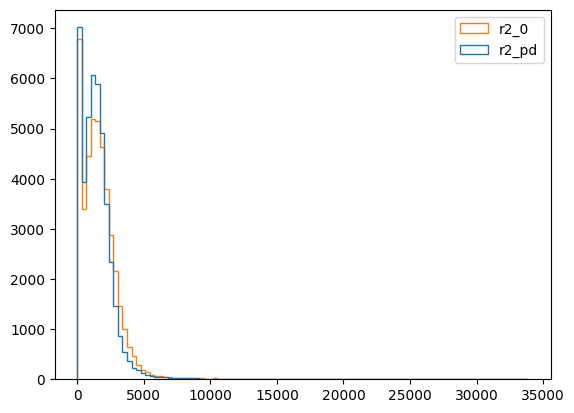

In [29]:
# r2df = pd.read_hdf(os.path.join(datadir, 'test_r2hits.h5'), 'r2df')
# print(r2df)
# _ = plt.hist([r2df.loc[r2df['theta_p'] > 0.5, 'r2_pd'], r2df.loc[r2df['theta_p'] > 0.5, 'r2_0']], bins=100, histtype='step', label=['r2_pd', 'r2_0'])
# plt.legend()
# r2df.loc[r2df['theta_p'] > 0.5, 'r2_pd'].std(), r2df.loc[r2df['theta_p'] > 0.5, 'r2_0'].std()

In [10]:
edf = pd.read_hdf(os.path.join(datadir, 'ringdetection\\digitized_x80_dx45_t1-3_dt2_120k_dcr0.h5'), 'edf')
print(edf)
print(edf.dtypes)
print(f'edf size is {sys.getsizeof(edf)/2**20:.3f} MiB')

            0      1      2      3      4      5      6      7      8      9  \
event                                                                          
0       False  False  False  False  False  False  False  False  False  False   
1       False  False  False  False  False  False  False  False  False  False   
2       False  False  False  False  False  False  False  False  False  False   
3       False  False  False  False  False  False  False  False  False  False   
4       False  False  False  False  False  False  False  False  False  False   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
119995  False  False  False  False  False  False  False  False  False  False   
119996  False  False  False  False  False  False  False  False  False  False   
119997  False  False  False  False  False  False  False  False  False  False   
119998  False  False  False  False  False  False  False  False  False  False   
119999  False  False  False  False  Fals

In [41]:
(edf['partin'] & (edf['nsignals'] > 4)).sum() / edf.shape[0]

0.426475

In [31]:
np.argwhere(((edf['nsignals'] > 20) & (~edf['partin']) & (edf['theta_p'] > 0.7)).to_numpy())

array([[   272],
       [  1054],
       [  1741],
       [  1810],
       [  2185],
       [  2278],
       [  3136],
       [  3198],
       [  3268],
       [  6702],
       [  7212],
       [  7703],
       [  8677],
       [  8950],
       [  9213],
       [ 10120],
       [ 10865],
       [ 11050],
       [ 11255],
       [ 11367],
       [ 11534],
       [ 11809],
       [ 12240],
       [ 12487],
       [ 13526],
       [ 13703],
       [ 13921],
       [ 14721],
       [ 15292],
       [ 15409],
       [ 16037],
       [ 16167],
       [ 16217],
       [ 16350],
       [ 17440],
       [ 19173],
       [ 20968],
       [ 21348],
       [ 21399],
       [ 21594],
       [ 22388],
       [ 24657],
       [ 25313],
       [ 26180],
       [ 26325],
       [ 26550],
       [ 27605],
       [ 28247],
       [ 28378],
       [ 28543],
       [ 29026],
       [ 29118],
       [ 29728],
       [ 30290],
       [ 30916],
       [ 31911],
       [ 32973],
       [ 33221],
       [ 33303

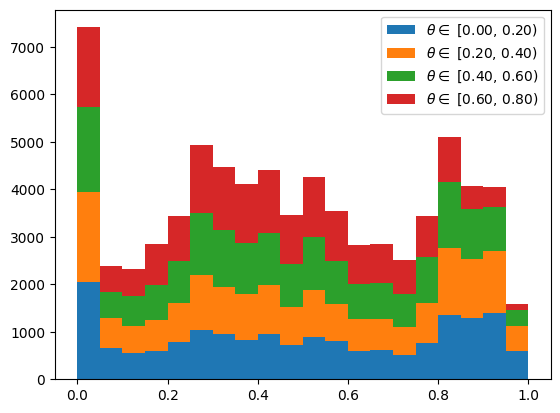

In [34]:
# sel = (edf['n0signals'] > 10) & (edf['nsignals']/edf['n0signals']>0.95)
# _, bins, _ = plt.hist(edf['theta_p'], bins=100)
# _ = plt.hist(edf.loc[sel, 'theta_p'], bins=bins)
# plt.semilogy()
tps = np.linspace(0, 0.8, 5)
bins = np.linspace(0, 1, 21)
data = []
labels = []
for i in range(tps.size-1):
  sel = (edf['n0signals'] > 10) & (edf['theta_p']>=tps[i]) & (edf['theta_p']<tps[i+1])
  data.append((edf['nsignals'] / edf['n0signals'])[sel])
  labels.append(rf'$\theta \in$ [{tps[i]:.2f}, {tps[i+1]:.2f})')
  
plt.hist(data, bins=bins, label=labels, histtype='barstacked')
plt.legend()

In [27]:
def plothits(edf: pd.DataFrame, event: int = 0):
  '''
  Отрисовка срабатываний в датафрейме edf в виде распределений по координатам и времени.
  Параметры:
  edf - датафрейм для отрисовки
  event - номер события для отрисовки
  '''  

  nch = sum([isinstance(col, int) for col in edf.columns])
  nxch = int(np.sqrt(nch))
  print(f'Number of channels: {nch} ({nxch}x{nxch})')
  print(f'Number of signal hits: {edf.at[event, "nsignals"]:d}')
  try:
    print(f'Number of total hits: {edf.at[event, "nhits"]:d}')
    print(f'beta = {edf.at[event, "beta"]:.4f}')
    print(f'theta_p = {edf.at[event, "theta_p"]/pi*180:.1f}°')
  except KeyError:
    pass
  
  dtype = np.uint8 if edf.iat[event, 0].dtype == 'bool' else edf.iat[event, 0].dtype
  data = edf.iloc[event, 0:nch].to_numpy(dtype)
  im = data.reshape((nxch, nxch))
  
  figxy = plt.figure(figsize=(6, 6))
  plt.imshow(im, cmap='viridis')
  plt.xlabel('X index', fontsize=14)
  plt.ylabel('Y index', fontsize=14)
  plt.tight_layout()

  figtime = None
  if dtype != np.uint8:
    figtime = plt.figure(figsize=(6, 4))
    _, bins, _ = plt.hist(data[data>0], bins=100, range=(0, 12), histtype='stepfilled')
    dt = bins[1] - bins[0]
    plt.xlabel('Thit, ns', fontsize=14)
    plt.ylabel(f'Hits/({dt:.3f} ns)', fontsize=14)
    plt.tight_layout()

  return figxy, figtime

Number of channels: 6400 (80x80)
Number of signal hits: 23
Number of total hits: 19
beta = 0.9971
theta_p = 42.8°


(<Figure size 600x600 with 1 Axes>, <Figure size 600x400 with 1 Axes>)

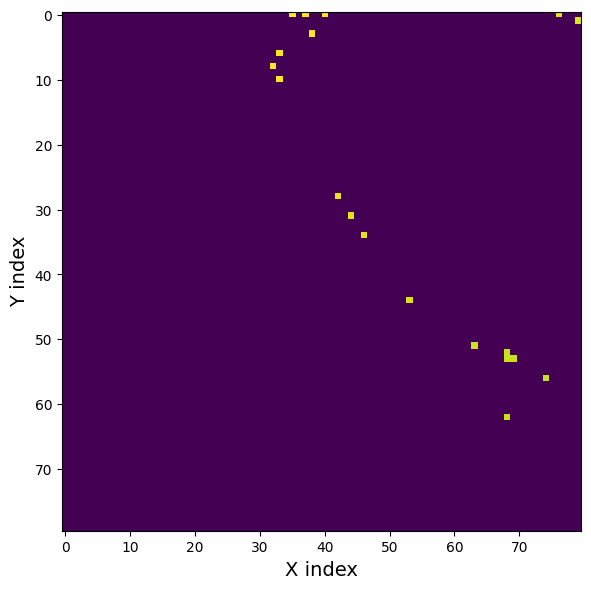

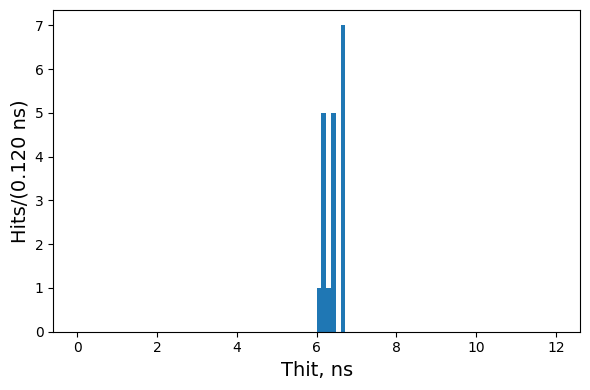

In [33]:
plothits(edf, 62616)